해당 한글화 커널은 2018 공개SW 컨트리뷰톤의 '캐글 속 커널 한글화 작업을 통한 데이터 사이언스 대중화' 프로젝트 주도하에 작성되었습니다. Rossman Store Sales Competition의 [Time Series Analysis and Forecasts with Prophet](https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet) Kernel을 한글화 하였습니다.

## 컴피티션 소개

로스만은 7개의 유럽국가에서 3,000개가 넘는 드러그 스토어를 운영하는 회사입니다. 또한, 최근 로스만 매장 관리자는 최대 6주의 일간 판매량을 예측하는 업무를 진행하고 있습니다. 매장의 판매량은 홍보를 포함하여 시장 경쟁, 학교 또는 지역의 휴일, 계절, 지역 등 많은 요인에 의해 영향을 받습니다. 수천 명의 관리자들은 자신들만의 배경 지식을 토대로 판매량을 예측하며, 매우 다양한 결과를 얻고 있습니다.

로스만은 독일 전체에 있는 1,115개의 매장 데이터를 바탕으로 다음 6주간의 일간 판매량을 예측하는 문제를 제시했습니다. 정확한 판매량 예측은 매장 관리자들이 효율적으로 직원들의 일정을 관리하고, 생산선 증가 및 동기 부여 관점에서 중요하게 여겨집니다. 우리가 로스만의 판매량을 확고하게 예측하는 모델 생성을 도와줌으로써 매장 관리자들이 더 중요한 것에 집중할 수 있도록 할 수 있습니다.

# 시계열 분석과 Prophet 라이브러리를 사용한 예측 

** 목표: **

- 데이터를 탐험해보자. (ECDF 라이브러리를 사용해 결측치를 다뤄보자.)
- 매장 형태와 매장 활동의 상관관계 분석을 해보자.
- 시계열 분석을 확장해서 수행해보자. (seasonal_decompose 라이브러리, 경향, 자기 상관성을 고려해보자.)
- Prophet 라이브러리를 사용해 다음 6주간의 판매량을 예측해보자.(Facebook의 방법론입니다.)

해당 커널은 시계열 분석에 초점을 두고 있습니다. 중요한 주제는 아직 밝혀지지 않았고, 다음 6주간의 일간 매출을 예측하기 위해 최근 Facebook이 소개한 Prophet이라는 새로운 방법을 사용하려고 합니다. 이 방법론은 휴일에 대해 모델링을 할 수 있는 좋은 특징을 가지고 있습니다. 마지막으로 끝 부분에 Seasonal ARIMA and Prophet의 장단점에 대해 논의하고자 합니다.

항상 하던대로 먼저 데이터를 살펴보려고 합니다. 데이터의 패턴과 존재하는 경향을 찾아내기 위해 여러가지 척도를 사용할 예정입니다. 추후의 분석을 위해서 기반을 탄탄하게 다져봅시다.

**스압주의**:

양은 많지만 시간을 투자할 가치가 있습니다. 해당 커널의 이전 버전이나 풀 버전을 [이곳](https://github.com/elena-petrova/rossmann_TSA_forecasts) 에서 확인할 수 있습니다.



재밌게 보세요!

![rossmann][1]


  [1]: https://kaggle2.blob.core.windows.net/competitions/kaggle/4594/media/rossmann_banner2.png

---

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 패키지 불러오기
# 기본 + 일 관련 패키지
import numpy as np
import pandas as pd
from pandas import datetime

# 데이터 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns # 더 괜찮은 시각화 툴
%matplotlib inline

# 통계 패키지
from statsmodels.distributions.empirical_distribution import ECDF

# 시계열 분석 패키지
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 페이스북이 만든 Prophet
from fbprophet import Prophet 

In [2]:
# 학습을 위한 훈련데이터 불러오기, Date Column이 존재하기 때문에 parse_dates 옵션을 True로 설정하고 날짜별로 정리하기 위해 인덱스로 지정
train = pd.read_csv('input/train.csv', 
                   parse_dates = True, index_col = 'Date')

# 추가적인 매장 데이터
store = pd.read_csv('input/store.csv')

# 시계열 단위 살펴보기
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## 탐험적 데이터 분석

첫번째로 우리는 훈련 데이터와 매장 데이터를 살펴보고 결측치 처리와 추후 분석을 위한 새로운 변수를 만들어 볼 예정입니다.

In [3]:
# 훈련 데이터의 형태와 데이터의 값들을 살펴보며 시작해봅시다.
print('In total: ', train.shape)
train.head()

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


##### Column 설명:
- Sales : 해당 일자에 대한 매출 (우리가 예측하고자 하는 Target 변수입니다.)
- Customers : 해당 일자에 대한 손님 수
- Open : 해당 일자에 대한 매장의 영업 유무
- Promo : 해당 일자에 대한 행사 유무
- StateHoliday : 해당 일자에 대한 지역 휴일 유무 (일반적으로 대부분의 매장은 지역 휴일에 영업을 하지 않습니다.)
- SchoolHoliday : 공립 학교들의 휴교 유무 (매장이나 일자가 해당 Feature의 영향을 받기도 합니다.)

우리는 시계열 데이터를 다루고 있습니다. 따라서 추후 분석을 위해 데이터를 잘 가공해야합니다. 또한, 데이터 셋에서 'Sales', 'Customers' 변수가 높은 상관관계를 가지고 있기 때문에 두개를 조합하여 새로운 변수를 생성할 예정입니다.


In [4]:
# 데이터 추출
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# 새로운 변수 생성
train['SalePerCustomer'] = train['Sales']/train['Customers']
# 통계적인 정보를 출력해주는 함수
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

데이터셋에 매출이 0인 날이 존재하더라도 고객이 평균적으로 하루에 9.50$를 사용한다는 것을 알 수 있습니다.

### ECDF: 경험적 누적 분포 함수

연속 변수들의 특징들을 살펴보기위해 ECDF을 확인해 봅시다.

* 데이터 분포의 적합(fit)을 평가하거나 서로 다른 여러 표본 분포를 비교할 때 사용합니다. 그리고 표본으로부터 모집단 백분위수를 추정할 수 있습니다. 본래 경험적 누적 분포 함수의 형태는 이산적인 계단 형태의 그래프를 나타내지만, Rossman Store Sales DataSet에서는 데이터의 개수가 많아 부드러운 곡선의 형태로 보입니다. 
[출처](https://blog.naver.com/jiehyunkim/220952781097)



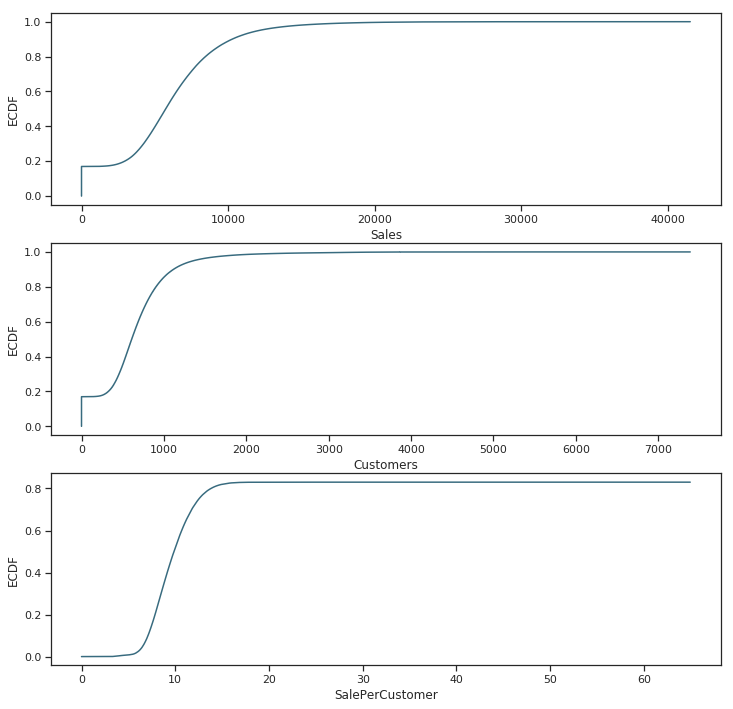

In [5]:
# seaborn 설정
sns.set(style = 'ticks') # 형태
c = '#386B7F'# 색
plt.figure(figsize = (12,12)) # 크기

# 매출의 ECDF
plt.subplot(311) # plot의 위치, 3개의 행에서 첫번째 행
cdf = ECDF(train['Sales']) # 매출의 ecdf 얻기
plt.plot(cdf.x, cdf.y, label = 'statmodels', color = c); # 그리기
plt.xlabel('Sales'); # x축 이름
plt.ylabel('ECDF'); # y축 이름

# 고객의 ECDF
plt.subplot(312) # plot의 위치, 3개의 행에서 두번째 행
cdf = ECDF(train['Customers']) # 고객의 ecdf 얻기
plt.plot(cdf.x, cdf.y , label = 'statmodels', color = c); # 그리기
plt.xlabel('Customers'); # x축 이름
plt.ylabel('ECDF'); #y축 이름

# 새로운 변수 고객 당 매출의 ECDF
plt.subplot(313) # plot의 위치, 3개의 행에서 세번째 행
cdf = ECDF(train['SalePerCustomer']) # 고객 당 매출의 ecdf 얻기
plt.plot(cdf.x, cdf.y, label = 'statmodels', color = c); # 그리기
plt.xlabel('SalePerCustomer'); # x축 이름
plt.ylabel('ECDF'); #y축 이름

20%에 가까운 매출, 고객의 값이 0을 나타내고 있습니다. 결측값 전처리가 필요하겠네요. 남은 80%의 매출은 10000보다 작은 값을 가지고 있습니다. 무엇이 매출이 0의 값을 갖도록 하는 걸까요? 단순히 매장이 해당 날짜에 운영을 하지 않았다는 것이 원인인지 알아봅시다.

### 결측값

<strong>매장의 휴업과 일일 매출이 0인 것의 관계</strong>

In [6]:
# 휴업한 매장 
zero_sales = train[(train.Open == 0) & (train.Sales == 0)]
print('In total: ', zero_sales.shape)
zero_sales.head()

In total:  (172817, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


172817개의 매장이 휴업한 기록이 있었습니다. 해당 수치는 관측치의 전체 양에 10%정도 입니다. 편향적인 예측 결과를 피하기 위해 이러한 값들을 버려야 합니다. 

여기에서, 휴업하지 않았는데 매출이 0인 매장은 무엇이 원인일까요?

In [7]:
# 영업을 했으나 매출이 0인 매장
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print('In total: ', zero_sales.shape)
zero_sales.head()

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


놀랍게도 영업을 했음에도 매출이 없는 매장이 있었습니다. 54일의 데이터가 있었고 다른 외부 요인이 있을 수 있다는 것을 유추해볼 수 있습니다.

In [8]:
print('휴업한 매장과 매출이 없는 날은 예측에 포함하지 않기로 합니다.')
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]

print('In total: ', train.shape)

휴업한 매장과 매출이 없는 날은 예측에 포함하지 않기로 합니다.
In total:  (844338, 13)


매장의 정보에 대해 살펴봅시다.

In [9]:
# 매장의 추가적인 정보
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


- Store: 매장의 고유 번호.
- StoreType: 4개의 다른 매장 형태를 나타내는 지표: a,b,c,d.
- Assortment: 매장을 구분하는 분류 단계: a = basic, b = extra, c = extended.
- CompetitionDistance: 근처의 경쟁 매장과의 거리.
- CompetitionOpenSince[Month/Year]: 경쟁 매장이 개업한지 대략적으로 얼마나 되었는지를 나타내는 기간.
- Promo2: 몇몇의 매장에 대해 행사를 지속하고 있는지를 나타내는 지표: 0 = store is not participating, 1 = store is participating.
- Promo2Since[Year/Week]: 해당 매장이 언제부터 Promo2에 참여하고 있는지를 나타내는 지표
- PromoInterval: Promo2가 시작되는 간격을 나타낸다. 주어진 월에 행사를 진행한다. 

In [10]:
# 결측치 확인
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

몇몇의 변수들에 대해 결측 값이 존재하므로 전처리가 필요합니다. CompetitionDistance 부터 시작해봅시다.

In [11]:
#Competitiondistance 변수에 존재하는 결측 값을 봅시다.
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


겉으로 보기에 데이터로부터 특정한 패턴 없이 단순히 결측된 것으로 보입니다. 이러한 경우에는 결측 값을 중간값으로 대체하는 것이 합리적인 방법이 될 수 있습니다.

In [12]:
# NaN 값을 중간값으로 채우기 
# inplace 옵션은 store 변수에 결측 값 처리를 한 데이터를 다시 할당하지 않고, 
# store 변수가 가진 데이터를 처리하도록 하는 옵션입니다. 검색해보세요!
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

이번에는 Promo2SinceWeek 변수의 결측값을 살펴봅시다. 이상하게 느껴지는 부분을 찾으셨나요?

In [13]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

Promo2의 값이 존재하지 않으면, 정보를 얻을 수 없었습니다. 그래서 이러한 값들을 0으로 채울 수 있고, 똑같은 방법으로 Competition으로부터 파생된 CompetitionOpenSinceMonth와 CompetitionOpenSinceYear 변수에 대해서도 처리할 수 있습니다.

In [14]:
# 남은 결측 값들을 0으로 채워봅시다.
store.fillna(0, inplace = True)

In [15]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [16]:
print('훈련 데이터셋과 매장 정보 데이터를 합쳐봅시다.')

# 매장 고유번호(Store)에 맞춰 내부 조인을 통해 양쪽에 매칭이 가능한 행에 대해서만 두개의 데이터셋을 합칩니다.
# 조인은 두개의 데이터셋을 합치는 연산으로 데이터베이스에서 배울 수 있습니다. 자세한 내용은 검색해 보시길 바랍니다.
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print('In total: ', train_store.shape)
train_store.head()

훈련 데이터셋과 매장 정보 데이터를 합쳐봅시다.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### 매장의 종류

이번에는 StoreType의 레벨의 차이점을 자세하게 살펴보려고 합니다. 그리고 Sales가 어떤 방법으로 분포되어 있는지 살펴보고자 합니다.

In [17]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


StoreType b 는 가장 높은 매출 평균을 가지고 있지만, 가장 적은 데이터로 구성되어있습니다. 이번에는 StoreType에 따라 가장 잘팔고 고객이 방문하는지 Sales와 Customers의 전체 합을 통해 살펴보도록 합시다.

In [18]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


In [19]:
train_store.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

명확하게 a 타입의 매장이 가장 높은 매출과 고객 수를 보유하고 있었으며, 뒤를 이어 d 타입의 매장이 2번째로 자리잡고 있었습니다. 

이번에는 행사의 기간을 포함해보는 것은 어떨까요? Seaborn의 facet grid는 기간을 고려해 시각화 하기 좋은 도구입니다.

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


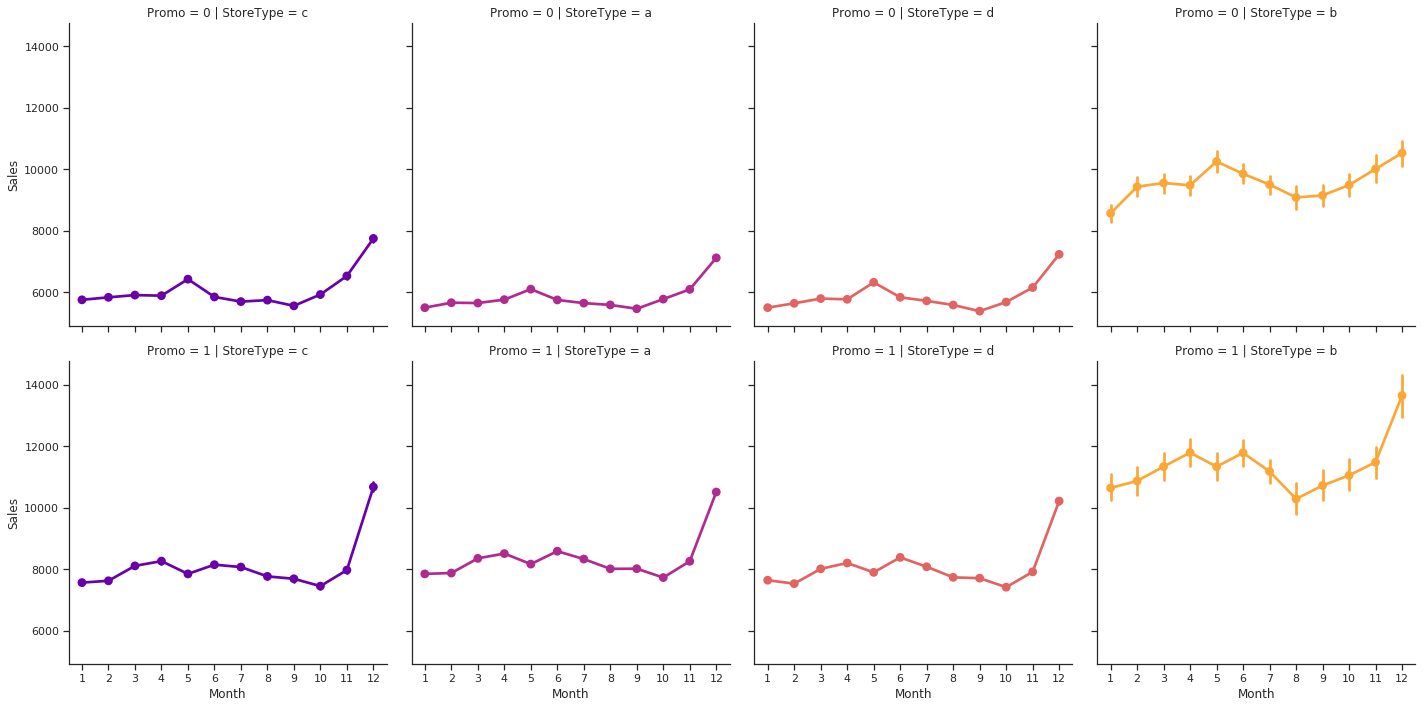

In [20]:
# 매출의 경향
sns.factorplot(data = train_store, x = 'Month', y = 'Sales',
              col = 'StoreType', # 매장의 타입에 따라 살펴보자
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo', # 행사를 진행하는 주기를 포함시켜보자
              color = c)

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


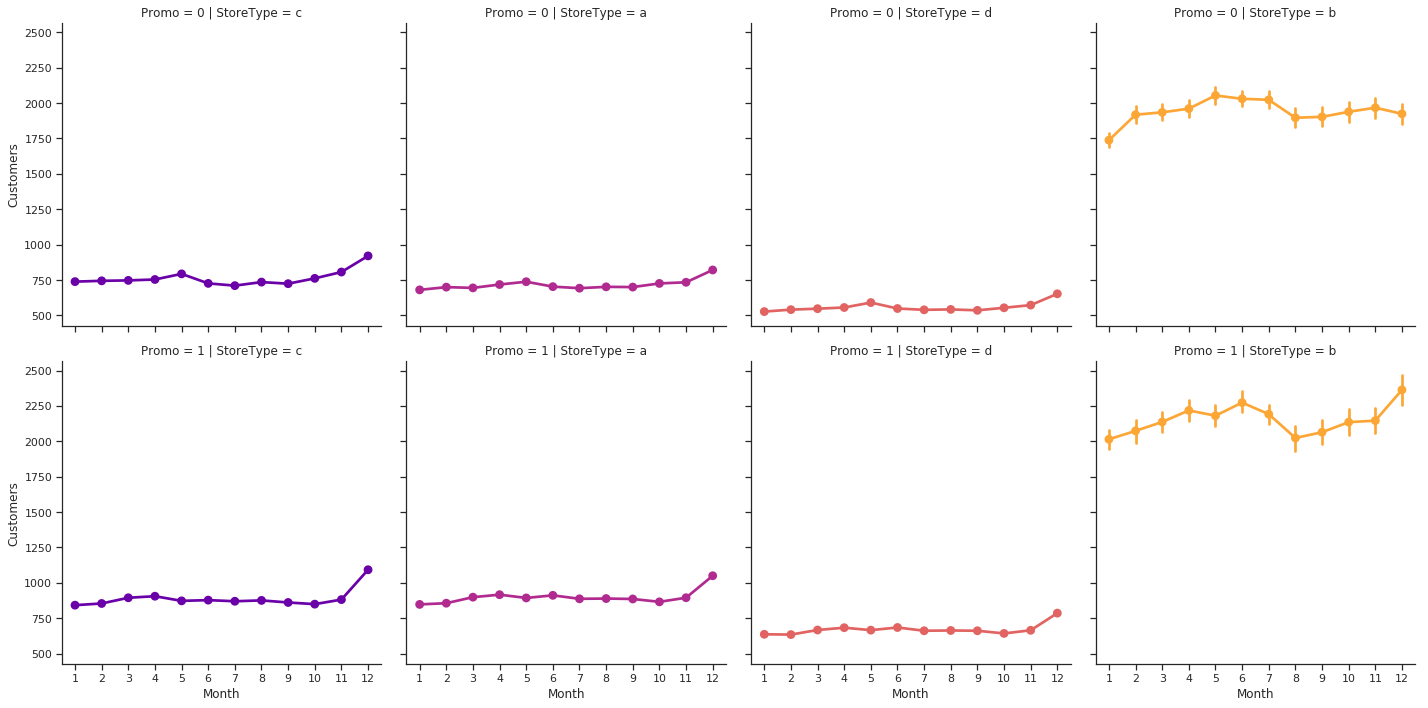

In [21]:
# 고객의 경향을 알아보자
sns.factorplot(data = train_store, x = 'Month', y ='Customers',
              col = 'StoreType', # 매장의 타입에 따라 살펴보자
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo', # 행사를 진행하는 주기를 포함시켜보자
              color = c)

모든 형태의 매장이 비슷한 경향을 따른다는 것을 확인할 수 있었지만, 값의 규모의 차이가 행사 유무 및 매장의 형태에 의존성을 보였습니다.

<strong>이미 모든 부분에서 매출이 크리스마스 연휴가 가까워짐에 따라 증가함을 확인할 수 있었습니다. 시계열 분석 부분에서 다시 계절의 영향과 경향에 대해 이야기 해봅시다.</strong>

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


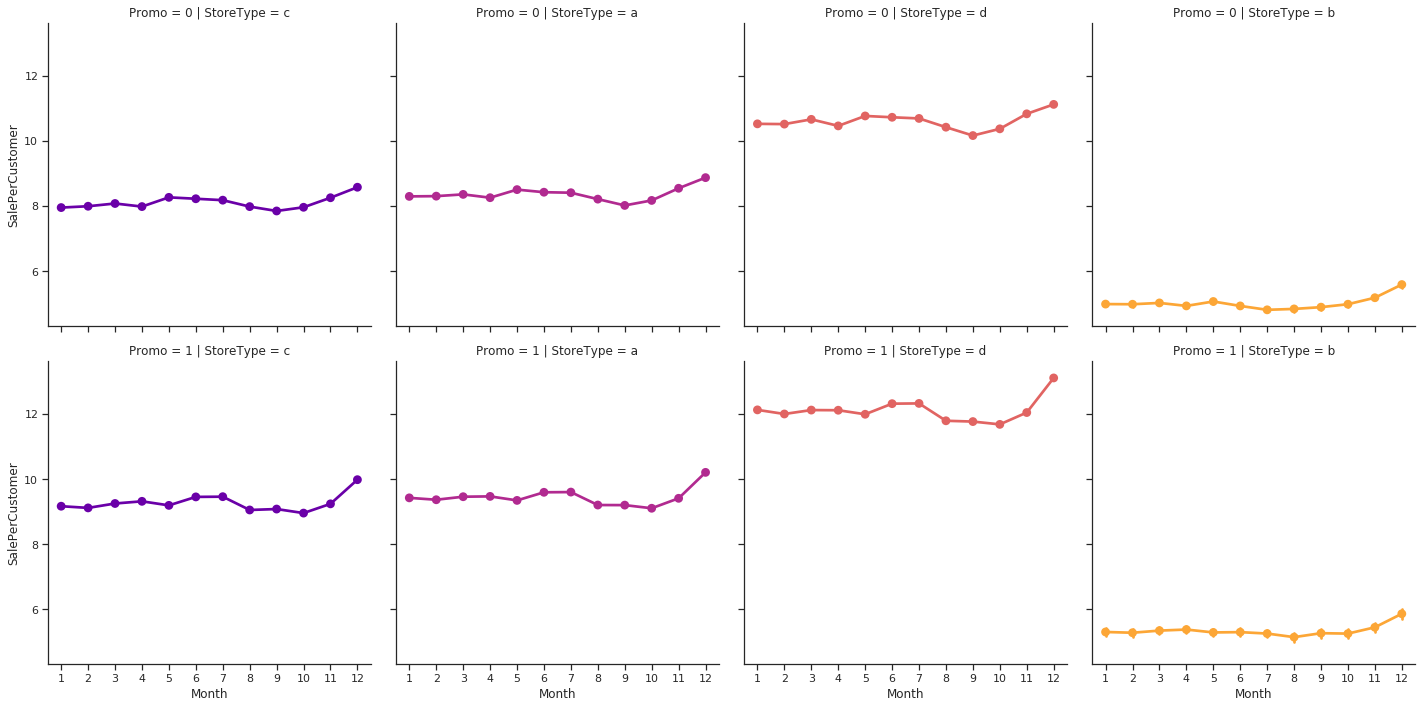

In [22]:
# 고객당 매출의 경향을 알아보자
sns.factorplot(data = train_store, x = 'Month', y ='SalePerCustomer',
              col = 'StoreType', # 매장의 타입에 따라 살펴보자
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo', # 행사를 진행하는 주기를 포함시켜보자
              color = c)

이전의 plot에서 b 형태를 가진 매장이 가장 높은 판매량을 보여주었었지만 가장 낮은 고객당 판매량을 보여주었습니다. 가장 높은 고객 당 판매량은 d 형태를 가진 매장으로 관측 되었습니다. 행사가 있을 때에는 12€ 근처, 없을 때에는 10€ 근처 결과를 보여주었습니다. a, c 형태에서는 9€ 의 결과를 보여주었습니다.

낮은 고객당 판매량을 가진 b 타입 매장의 손님들은 개수가 적거나 적은 양의 물건들을 구매했다는 것을 알 수 있습니다. 추가적으로 전체 기간을 통틀어 최소한의 판매량과 고객 수를 산출한다는 것을 알 수 있었습니다.


/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


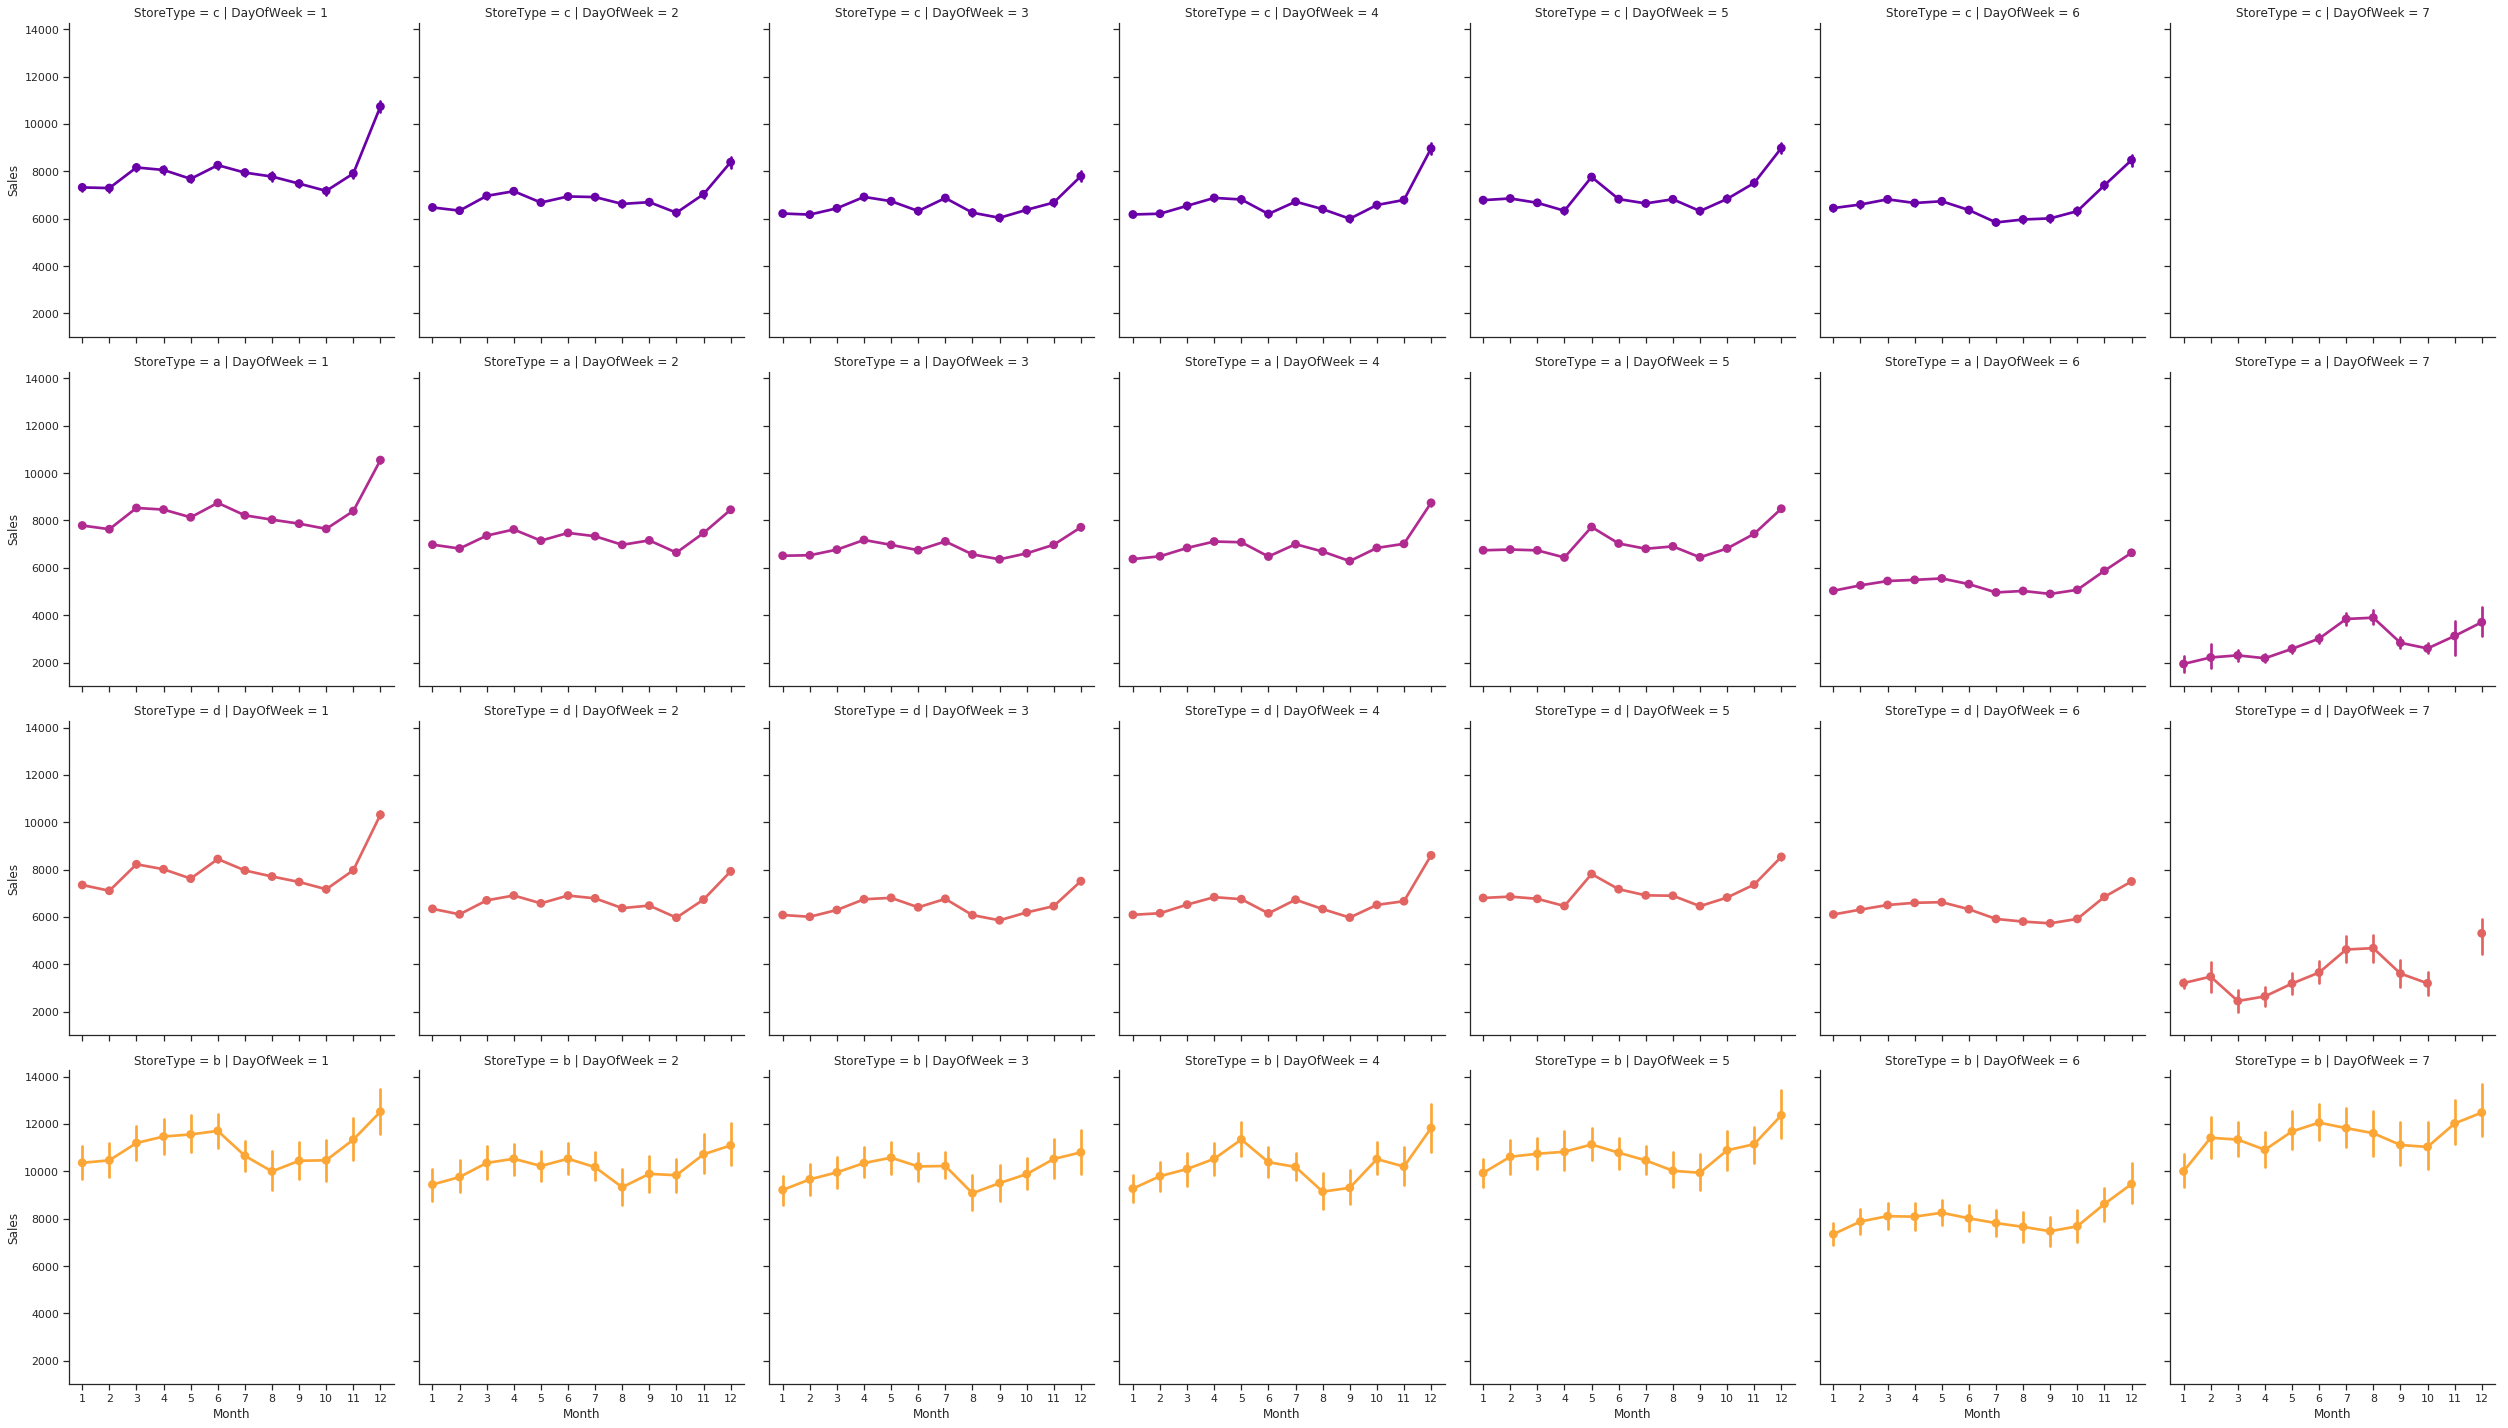

In [23]:
# customers
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # 요일별로 살펴봅시다
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # 매장의 형태를 추가해 고려해봅시다
               color = c) 

c 형태의 매장은 일요일에 영업을 하지 않는다는 것을 알 수 있습니다. 한가지 재미있는 것은 d 형태의 매장은 10월과 11월의 일요일에는 영업을 하지 않습니다.

그러면, 일요일에 영업을 하는 매장들은 어떤곳들이 있을까요?

In [24]:
# 일요일에 문을 여는 매장들
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

우리의 데이터 분석을 위한 전처리를 마무리하기 위해 마지막으로 영업을 하는 매장들에 대해 경쟁 업체가 개업한 시기, 행사가 시작된 시기를 고려한 새로운 변수를 더하도록 하겠습니다.

In [25]:
# 경쟁업체의 개업 시기를 고려한 변수
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
# 행사가 시작된 시기를 고려한 변수
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0
# 결측값을 0으로 채우기
train_store.fillna(0, inplace = True)

# 스토어 형태에 대한 행사 시작시기와 경쟁업체의 개업시기의 평균
train_store.loc[:,['StoreType', 'Sales','Customers','PromoOpen','CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


### 상관관계 분석

방금 데이터에 새로운 변수를 추가했습니다. 이제 모든 변수에 대해 상관관계를 확인해보려고 합니다.
`seaborn`의 heatmap을 통해 살펴봅시다.

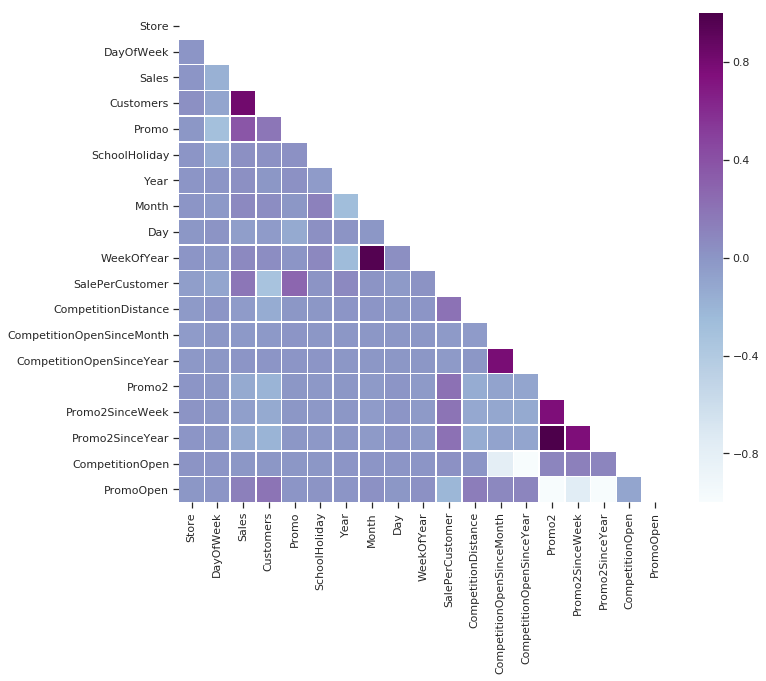

In [26]:
# 상관관계 매트릭스 계산
# Open 을 제외한 데이터를 가지고 상관관계를 확인해봅시다.
corr_all = train_store.drop('Open', axis = 1).corr()

# mask 생성 ( 상관관계 매트릭스는 자기 자신과는 1의 상관관계를 나타내고, 대각선을 기준으로 대칭이기 때문에 
# mask를 이용해 값을 출력하지 않도록 합니다.)
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 매트릭스를 그릴 matplotlib 피규어(도화지라 생각하시면 편합니다.) 생성
f, ax = plt.subplots(figsize = (11,9))

# 상관관계 매트릭스를 heatmap 형태로 그리기
sns.heatmap(corr_all, mask=mask,
           square = True, linewidths = .5, ax = ax, cmap = 'BuPu')
plt.show()

이전에도 말했지만 매출과 고객의 수는 강한 양의 상관관계를 가지고 있다는 것을 확인할 수 있습니다. 그리고 매장의 행사 진행 유무와도 고객의 수가 양의 상관관계를 보여주고 있었습니다.

하지만, 연달아 행사가 진행됨을 나타내는 `Promo2`가 1임에도 고객의 수 및 매출량은 비슷한 수준이거나 감소하기도 했습니다. 이는 heatmap에서 밝은 색으로 표현된 음의 상관관계를 통해 알 수 있습니다. 또 비슷한 음의 상관관계로는 행사의 유무와 요일 사이에서 찾아볼 수 있습니다. (이는 주말에 행사를 잘 진행하지 않는다는 것을 의미합니다.)

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


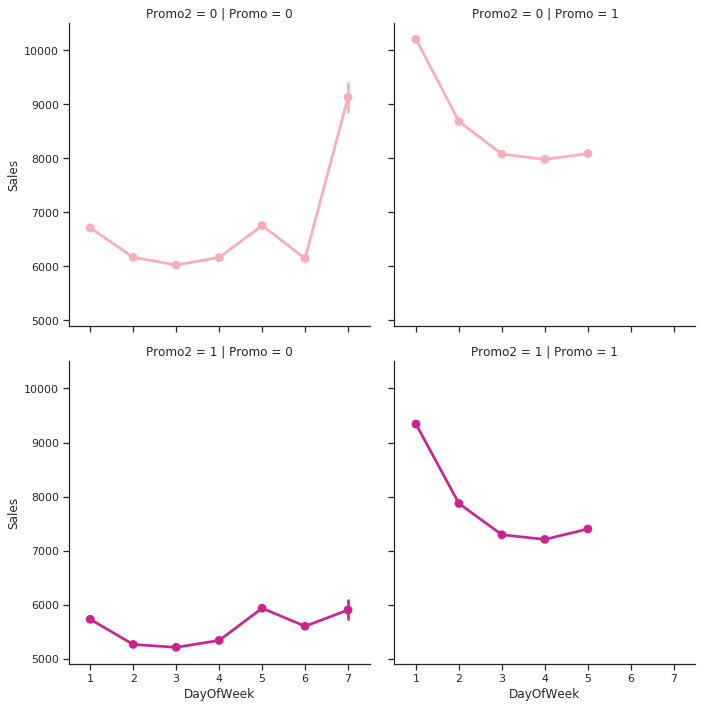

In [27]:
# 고객 당 판매량의 경향을 살펴봅시다
sns.factorplot(data = train_store, x= 'DayOfWeek', y = 'Sales',
              col = 'Promo',
              row = 'Promo2',
              hue = 'Promo2',
              palette = 'RdPu')

***여기서 몇가지 확인할 수 있습니다.***

- 행사가 없는 경우에 (`Promo`와 `Promo2`의 값이 0인) 판매량의 최고치는 일요일에 나타났습니다. c 형태인 매장이 일요일에 영업을 하지 않는데도 신기한 결과가 나왔습니다. 이 부분에서 a,b,d 형태의 매장이 데이터의 주를 이룬다는 것을 알 수 있습니다.
- 반대로 행사가 있는 경우에는 월요일의 판매량이 가장 높다는 경향을 찾을 수 있었습니다. 로스만 마케팅 캠페인의 좋은 지표가 될 수 있겠습니다. `Promo`와 `Promo2`의 값이 둘다 1인 매장에서도 비슷한 경향을 찾을 수 있었습니다.
- `Promo2` 하나로는 판매량에 큰 변화를 주기에 충분하지 못했습니다. (상관도가 없었다는 의미입니다.) heatmap에서 밝은 색을 나타내는 것으로도 확인할 수 있습니다.

## 탐험적 데이터 분석의 결론 ###

- 대부분의 판매량과 고객은 a 형태의 매장에서 일어난다.
- 최고의 고객 당 판매량을 나타낸 형태는 d 형태이다. 이 사실에서 이득을 취하기 위해서는 로스만은 더 크고 다양한 제품을 공급하는 것을 고려해야한다.
- 낮은 고객당 판매를 나타낸 형태는 b 형태이다. 이 부분에서는 고객들이 필수적인 작은 제품들을 선택한다는 사실을 알 수 있다. b 형태의 매장에서는 꾸준히 최소의 매출과 최소의 고객을 유치하므로 큰 잠재력을 가진 매장 형태라고 할 수 있다.
- 고객들은 행사를 진행하는 월요일에 구매하거나 행사가 없는 일요일에 구매하는 경향이 있다.
- `Promo2`는 혼자서는 매출에 큰 영향을 끼칠 수 없다.

### 매장 형태에 따른 시계열 분석


무엇이 시계열 문제와 일반적인 회귀 문제를 다르게 만들까요?
- 시간에 의존적이라는 점, 선형 회귀의 기본적인 가정은 관측한 데이터들이 시간에 독립적이라는 것 입니다.
- 증가하거나 감소하는 경향을 보이면서, 대부분의 시계열 데이터는 계절에 영향을 받는 형태를 가지고 있습니다. 우리 데이터에서도 크리스마스에 가까워지면 매출이 올라가는 것을 확인해볼 수 있었습니다.

개개인의 매장 대신에 매장 형태에 따른 시계열 분석 모델을 만들어보려고 합니다. 이러한 접근의 주된 장점은 표현하기 간결하다는 점과 다른 경향과 계절적인 전체적인 것을 확인해 볼 수 있다는 점 입니다.

이번에는 시계열 데이터의 경향, 계절성, 자기상관에 대해 살펴볼 예정입니다. 분석의 끝부분에서, seasonal ARIMA 모델을 사용해보려고 합니다. 하지만 우리가 집중할 부분은 이게 아닙니다. 대신에 데이터를 조금 더 이해해보고 Prophet 방법을 사용해 예측해봅시다. 

### 계절성

***각 그룹을 대표하는 매장 형태로부터 4개의 매장을 뽑아 살펴봅시다.***
- a 형태의 매장에서는 2번 매장
- b 형태의 매장에서는 85번 매장
- c 형태의 매장에서는 1번 매장
- b 형태의 매장에서는 13번 매장

조금 더 명확하게 경향을 보기 위한 방법으로 `resample`을 사용하여 다운 샘플링을 해봅시다.

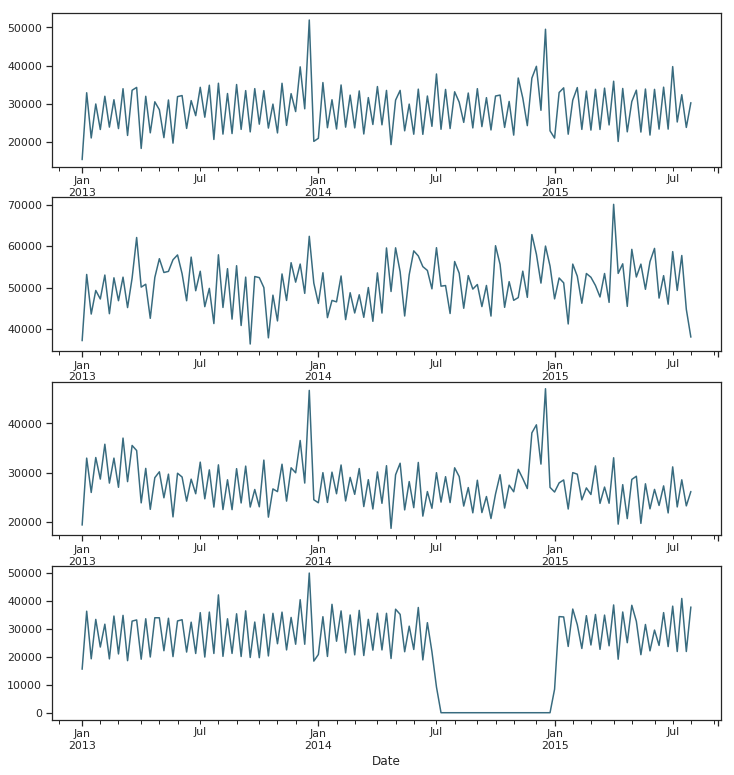

In [28]:
# 준비 : 입력을 실수로 만들기.
train['Sales'] = train['Sales'] * 1.0

# 매장 형태
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # 순서 조정
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

# 4개의 plot을 그리기위해 subplot(도화지) 4개 생성
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12,13))

# 매장 형태별로 `resample`적용
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

a, c 형태의 매장은 매출이 크리스마스 근처에서 최대치를 나타내고 이후 휴일에는 감소하는 경향을 보였다. d 형태의 매장에서도 우리가 확인을 할 수 있었으나 2014년 7월부터 2015년 1월까지 해당 매장이 영업을 하지않아 어떤 정보도 얻을 수 없었다.

### 연도별 경향

다음은 시간의 흐름에 따른 경향을 확인하려고 합니다.

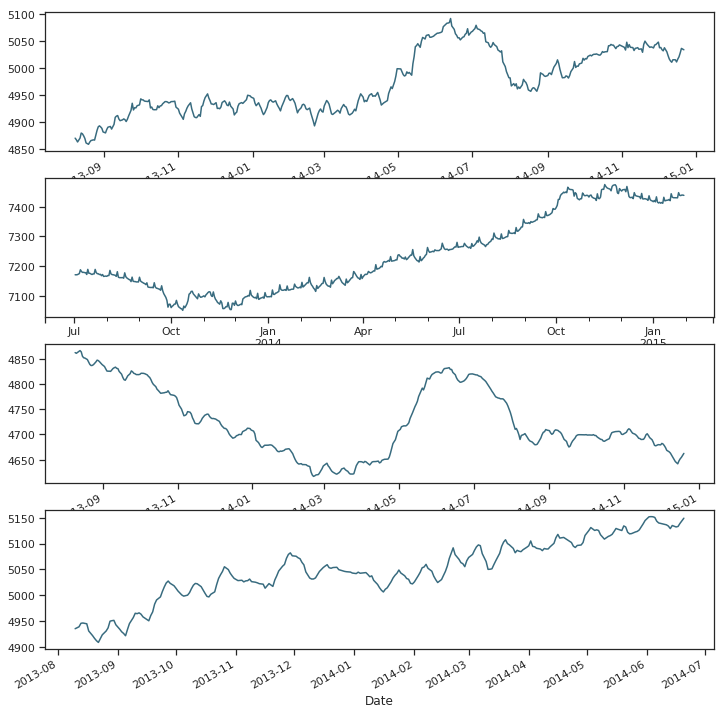

In [29]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12,13))

# 월별
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color=c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color=c, ax = ax4)

전체적으로 매출이 증가하는 것을 확인할 수 있었지만 c 형태의 매장은 그러지 않았습니다. a 형태의 매장은 데이터셋에서 가장 많은 매출을 나타내고 있음에도 감소하는 형태인 c 형태와 비슷한 모자 형상의 그래프를 확인할 수 있습니다.

### 자기 상관성

다음은 우리의 시계열 분석에서 자기상관성(Autocorrelation) 함수(ACF)와 편 자기상관성(Partial Autocorrelation) 함수(PACF)의 그림을 확인보려고 합니다.

자기상관성은 시계열에서 이전 시점으로부터 생겨난 오차항이 현재의 오차항에도 포함되는것을 나타내는 것이다.
ACF는 이전 시점의 오차항을 가진 시계열과 현재 시계열의 상관계수의 척도를 계산한다. 예를 들어 과거의 오차항이 5개라고 했을 때 ACF 는 현재의 시계열 데이터('t1' ... 'tn')와 ('t1 - 5'...'tn - 5')를 비교한다.

FACF는 ACF와 동일하게 이전 시점의 오차항을 가진 시계열과 현재 시계열의 상관계수의 척도를 계산하지만, 그 사이의 표현되는 변동성을 제거한다는 차이점이 있다. 예를 들어 과거 오차항이 5개이고 상관관계가 확인되면, 오차항 1개 ~ 4개에 대한 만큼의 영향을 제거한다. (설명이 조금 어렵습니다 ㅠㅠ)


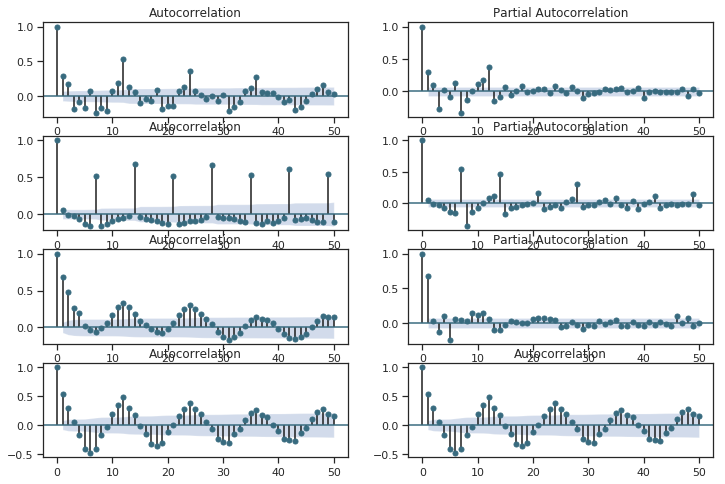

In [30]:
# 그림을 그리기 위한 Subplot(도화지) 준비
plt.figure(figsize = (12, 8))

# a 형태의 매장에 대해 acf, pacf
plt.subplot(421); plot_acf(sales_a, lags= 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# b 형태의 매장에 대해 acf, pacf
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# c 형태의 매장에 대해 acf, pacf
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# d 형태의 매장에 대해 acf, pacf
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

plot을 가로 방향을 짝으로 보시면 되겠습니다. 일반적으로 이런 plot들은 연속된 데이터에 대해 자기자신과의 상관관계를 보여줍니다. x개의 시간 단위(lag)로 자기 상관관계를 살펴봅니다.

plot의 쌍에서 일반적인 두가지를 확인해 볼 수 있는데: 시계열 데이터의 임의성이 없다는 점과 lag가 1일때 매우 높은 값을 갖는다는 것입니다.
- a, b 형태 : 두개의 형태는 특정한 lag 값들에서 계절성을 보여줍니다. a 형태의 경우 매 12번째 관측값(12, 24, 36 ... )에서 뾰족한 형태의 양수 값을 가집니다. b 형태의 경우 1주일에 한번씩 (7, 14, 21, 28...) 뾰족한 형태의 양수 값을 갖는다는 것을 볼 수 있었습니다.
- c, d 형태 : 이 두가지 형태는 조금 더 복잡합니다. 각 관측치들이 인접한 관측치들과 관련되어 있는 것을 볼 수 있습니다.

### 시계열 분석과 Prophet을 사용한 예측

***첫번째 매장에 대해 다음 6주간의 매출을 예측하기***

Facebook의 핵심 데이터 사이언스 팀이 최근에 Prophet이라는 시계열 데이터 예측에 사용되는 새로운 패키지를 공개했습니다. 연간, 주간 계절성과 휴일을 고려한 비선형 경향을 나타내는 Additive Model을 기반으로 만들어져 있습니다. 

In [31]:
# 데이터 불러오기
df = pd.read_csv('input/train.csv', low_memory = False)

# 매출이 없는 매장이나 문을 닫은 매장 데이터 제외
df = df[(df['Open'] != 0) & (df['Sales'] != 0)]

# 1번 매장의 매출 가져오기 ( c 형태의 매장임 )
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# 정렬하기 2013 -> 2015 순서로 (인덱스 기준으로는 내림차순)
sales = sales.sort_index(ascending = False)

# datetime64로 표현( 내부적으로는 int64로 표현된다고 합니다.)
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [32]:
# prophet documentation을 확인해보면 모든 변수는 특정한 이름을 가져야 한다고 합니다.
sales = sales.rename(columns = {'Date' : 'ds',
                               'Sales' : 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


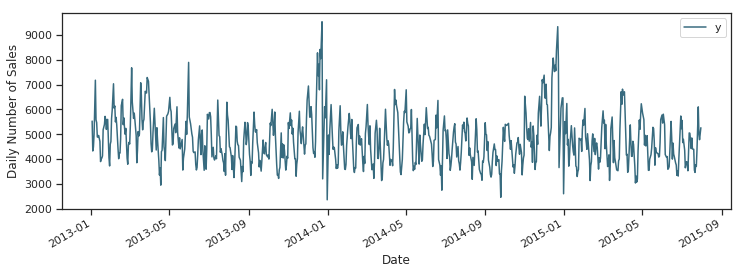

In [33]:
# 일간 판매량 그려보기
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### 휴일 모델링하기

Prophet은 휴일에 대한 모델링을 가능하게 합니다. 한번 확인해 봅시다.

지역 휴일(`StateHoliday`) 변수는 그 지역의 휴일을 나타내고, 대부분의 매장들은 일반적으로 휴업을 합니다. 공립 학교의 휴교(`SchoolHoliday`)시에는 특정한 몇몇의 매장만 휴업합니다.

In [34]:
# 휴일 DataFrame을 만들어봅시다.
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & 
                 (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday' : 'state_holiday',
                     'ds' : pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday' : 'state_holiday',
                      'ds' : pd.to_datetime(state_dates)})

holidays = pd.concat((state,school))
holidays.head()

,ds,holiday
0,2015-06-04,state_holiday
1,2015-06-04,state_holiday
2,2015-06-04,state_holiday
3,2015-06-04,state_holiday
4,2015-06-04,state_holiday


In [35]:
# 신뢰 구간을 95%로 설정한다. (Prophet의 기본값은 80%)
my_model = Prophet(interval_width = 0.95, holidays = holidays)
my_model.fit(sales)

# 데이터를 모델에 fit 했으니 DataFrame을 앞으로의 6주로 확장해봅시다.(날짜 새로 만들기.)
future_dates = my_model.make_future_dataframe(periods = 6*7)

print('First week to forecate.')
future_dates.tail(7)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecate.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [36]:
# 예측
forecast = my_model.predict(future_dates)

# 마지막 주 예측 결과
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4318.774719,2661.502575,6084.108159
817,2015-09-06,4273.892619,2568.877541,5926.031403
818,2015-09-07,4515.589303,2897.414103,6221.803458
819,2015-09-08,4005.217425,2299.619012,5721.874165
820,2015-09-09,3874.446282,2224.795200,5467.298472
821,2015-09-10,3761.266702,2139.467266,5331.700453
822,2015-09-11,4004.660144,2430.045114,5618.900942


예측 결과를 나타내는 DataFrame은 `yhat`(미래 예측값을 나타냄) 컬럼을 포함하고 있습니다. 또한, 우리가 설정한 95%의 신뢰구간으로 된 컬럼도 포함하고 있습니다.

In [37]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plot에서 우리의 시계열 데이터(또는 관측치)는 검은 점이고, 예측한 값은 파랑선, 신뢰구간은 하늘색으로 색칠된 부분입니다.

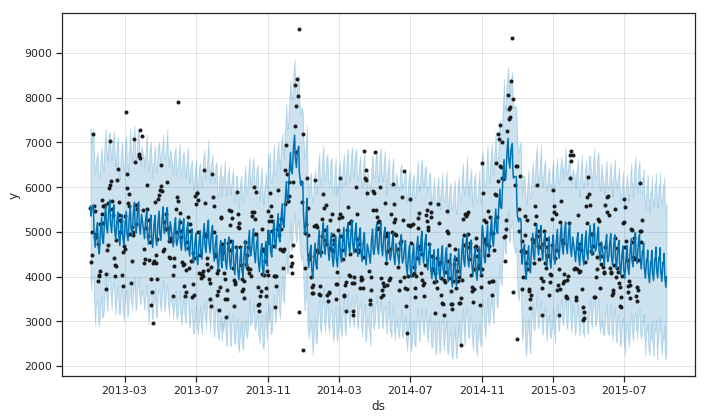

In [38]:
# 예측 시각화
my_model.plot(forecast);

Prophet을 사용해 매출의 경향을 찾아보고 값을 예측해보았습니다.

또 다른 Prophet의 큰 특징으로는 예측값으로부터 성분을 뽑아내는 것입니다. Component plot을 확인해보면 얼마나 일간, 주간, 연간 패턴이 많이 포함되어있는지 또, 휴일은 얼마나 많이 전체 예측값에 영향을 끼치는지를 쉽게 알 수 있습니다. 

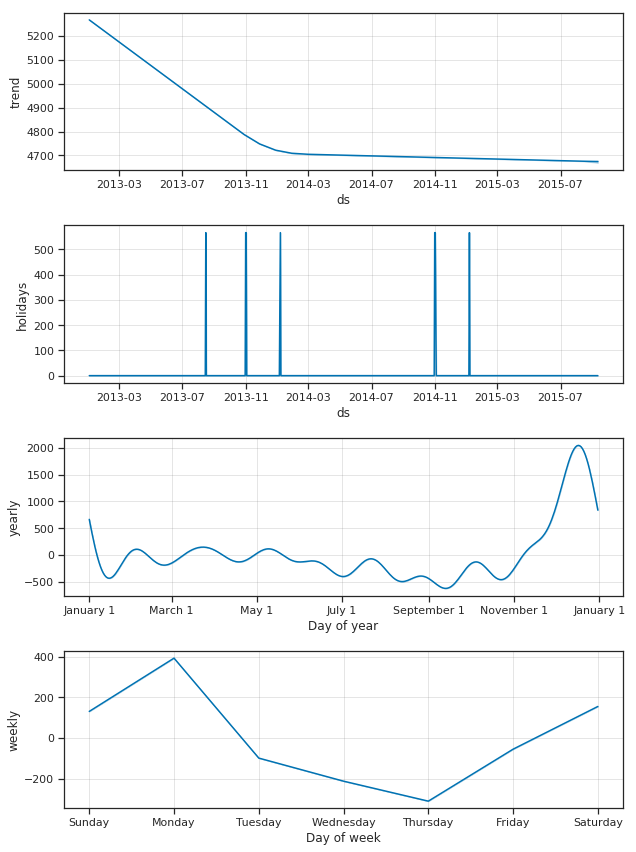

In [39]:
my_model.plot_components(forecast);

첫 번째 plot은 1번 매장의 월간 판매량을 나타냅니다. 선형적으로 감소하는 형태를 보이네요. 두 번째 plot은 모델에 포함된 휴일간 차이를 보여줍니다. 세 번째 plot은 지난주의 매주 판매량이 다음 주 월요일로 갈수록 커지고 있다는 사실을 보여주고 있습니다. 반면에 마지막 네 번째 plot은 가장 바쁜 계절이 크리스마스 휴일 동안이라는 것을 알려줍니다.

### 시계열 예측의 결론

지금까지 `seasonal_decompose()`, `ACF`, `PCF`, `Prophet` 모델을 사용해보고 plot을 확인해보며 시계열 분석에 대해 논의해 보았습니다. 

우리가 진행했던 시계열 데이터 예측의 잘된 부분과 부족했던 부분에 대해 짚어보고 마무리하도록 하겠습니다.
***Advantages***
- 시계열 예측에는 시간 종속, 계절성, 휴일을 모두 고려하는 아주 좋은 도구들이 많습니다. 
- R에서는 `forecast` 패키지의 `auto.arima()`를 사용하면 구현이 매우 편합니다.

***Drawbacks***
- 모델의 예측력을 높여줄 수 있는 외부 feature들과의 상호작용을 찾지 못했습니다. (이번 분석의 경우 `Promo`, `CompetitionOpen` 변수가 그랬습니다.)
- Prophet이 ARIMA의 자동화된 솔루션을 제공하지만, 아직 개발중인 방법론이기도하고 안정화가 되지 않았습니다. (지금은 모르겠네요! 원문이 쓰여진지 1년이 지났습니다.)
- ARIMA 모델이 계절성을 고려한 모델로 적용되기 위해서는 4~5번의 계절 변화(1년 이상)가 포함된 데이터가 필요합니다. 새로운 기업들에 대해서는 큰 단점으로 작용될 것 같습니다.
- 계절성을 고려한 ARIMA 모델은 7개의 hyper parameter 조정이 필요합니다. hyper parameter 조정은 예측 프로세스 속도에 상당한 영향을 끼칩니다.

읽어주셔서 진심으로 감사합니다. 추천 부탁드릴게요!